<hr style="border-color: black; border-style: groove;">
<center><h3> CS 452/552 Data Science with Python </h3></center>
<center><h3> Project 3 </h3></center>
<center><h3> Classification Challange - Credit Card Fraud Detection </h3></center>
<center><h3> Batuhan Erden </h3></center>
<hr style="border-color: black; border-style: groove;">

<h3> Imports </h3>

In [826]:
import random
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn import svm, linear_model, metrics, preprocessing, model_selection, neural_network

<h3> Global Constants </h3>

In [827]:
DATASET_PATH = "./"

<h3> Read dataset from csv </h3>

In [828]:
dataset = pd.read_csv(DATASET_PATH + "creditcard.csv")
dataset = dataset.rename(columns={"Class": "Fraud"})  # Rename feature 'Class' to 'Fraud'

dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Fraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<h3> Plot to see how unbalanced the data is </h3>

492 frauds out of 284807 transactions which is 0.1727% percent of all transactions..


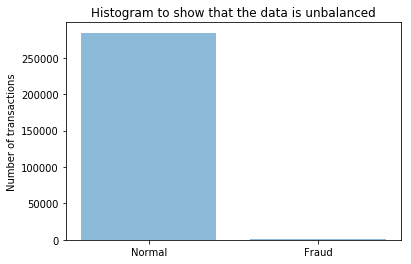

In [829]:
# Calculate
fraud_column_counts = dataset.Fraud.value_counts()

num_fraud = fraud_column_counts[1]
num_transactions = sum(fraud_column_counts)

print("{} frauds out of {} transactions which is {:.4f}% percent of all transactions..".
      format(num_fraud, num_transactions, num_fraud / num_transactions * 100))

# Plot
plt.title("Histogram to show that the data is unbalanced")
plt.ylabel('Number of transactions')

plt.xticks([0, 1], ["Normal", "Fraud"])
plt.bar([0, 1], [num_transactions - num_fraud, num_fraud], align="center", alpha=0.5)
 
plt.show()

<h3> Ignore features that have almost no effect on the frauds </h3>

In [830]:
mean_threshold = 0.6

v_features = dataset.iloc[:, 1:29].columns
v_features_to_drop = ["Time"]

for v_feature in v_features:
    mean_fraud = np.mean(dataset[v_feature][dataset["Fraud"] == 1])
    
    if -mean_threshold <= mean_fraud <= mean_threshold:
        v_features_to_drop.append(v_feature)

dataset = dataset.drop(v_features_to_drop, axis=1)

print("Features to be ignored: %a" % v_features_to_drop)
dataset.head()

Features to be ignored: ['Time', 'V8', 'V13', 'V15', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0


<h3> Normalize amounts </h3>

In [831]:
dataset["Amount"] = preprocessing.StandardScaler().fit_transform(dataset["Amount"].values.reshape(-1, 1))
dataset.iloc[:, dataset.columns == "Amount"].head()

,Amount
0,0.244964
1,-0.342475
2,1.160686
3,0.140534
4,-0.073403


<h3> Minimize and shuffle the dataset </h3>

In [864]:
safe_transactions = dataset[dataset["Fraud"] == 0]
fraudulent_transactions = dataset[dataset["Fraud"] == 1]

random_safe_transactions = safe_transactions.sample(n=len(fraudulent_transactions))

data_minimized = pd.concat(([fraudulent_transactions, random_safe_transactions]), axis=0)
data_minimized = data_minimized.sample(frac=1)  # Shuffle the dataset

print("Safe == Fraudulent? --> {}".format(len(data_minimized) / 2 == len(fraudulent_transactions)))
data_minimized.head()

Safe == Fraudulent? --> True


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud
214662,0.467992,1.100118,-5.607145,2.204714,-0.578539,-0.174200,-3.454201,-1.065016,-5.416037,4.497929,-5.019610,-7.914989,-4.472014,-5.856998,-2.243178,-0.173814,0.983481,0.128700,1
80427,-1.519120,3.424339,-3.540469,1.669922,-0.448989,-1.676307,-0.807759,-0.471705,-1.147762,0.771071,0.494893,-2.480540,0.861134,3.909449,1.026224,-1.022979,0.749636,-0.323004,0
157585,1.934946,0.650678,-0.286957,3.987828,0.316052,-0.099449,-0.021483,0.508730,1.072955,-0.427567,-2.777649,1.571080,0.908650,-0.122016,-0.104110,-1.684022,-0.173602,-0.349231,1
150662,-5.839192,7.151532,-12.816760,7.031115,-9.651272,-2.938427,-11.543207,-3.494276,-13.320789,8.460244,-17.003289,-14.094452,-12.661696,-18.912494,-6.626975,4.008921,2.462056,0.910406,1
150687,-10.300820,6.483095,-15.076363,6.554191,-8.880252,-4.471672,-14.900689,-4.358441,-14.533162,7.588741,-15.835719,-11.567006,-11.467430,-19.172996,-6.969856,2.211756,1.508748,-0.349231,1


<h3> Prepare inputs and labels </h3>

In [833]:
def get_inputs_and_labels(data):
    inputs = data.iloc[:, data.columns != "Fraud"]
    labels = data.iloc[:, data.columns == "Fraud"]

    inputs = np.array(inputs)
    labels = np.array(labels).flatten()
    
    return inputs, labels
    
mini_X, mini_y = get_inputs_and_labels(data_minimized)
X, y = get_inputs_and_labels(dataset)

mini_X_train, mini_X_test, mini_y_train, mini_y_test = model_selection.train_test_split(
    mini_X, mini_y, test_size=.3, random_state=0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=0)

<h3> Test the performance of the dataset using K-Fold Cross Validation </h3>

In [847]:
def test_using_kfold(n_splits, classifier, X, y):
    kfold = model_selection.KFold(n_splits=5, shuffle=False)
    scores = []

    # Test
    for train_index, test_index in kfold.split(X):
        classifier.fit(X[train_index], y[train_index])
        score = classifier.score(X[test_index], y[test_index])

        scores.append(score)
        print("....", end="....")
    
    # Print the average score
    print("\n- Average Score of {:d}-Fold Cross Validation: {:.2f}%".format(n_splits, np.mean(scores) * 100))

<h3> Calculate Confusion Matrix </h3>

In [850]:
def compute_confusion_matrix(classifier, test, predictions):
    np.set_printoptions(precision=4)
    confusion_matrix = metrics.confusion_matrix(test, predictions)
    
    # Print Confusion Matrix
    print("- Confusion Matrix:")
    print(confusion_matrix)
    
    # Print Normalized Confusion Matrix
    confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    print("- Normalized Confusion Matrix:")
    print(confusion_matrix_normalized)
    
    # Print the prediction accuracy of fraudulent transactions
    print("- Prediction accuracy of fraudulent transactions (Recall Accuracy): {:.2f}%"
          .format(confusion_matrix_normalized[1, 1] * 100))

<h3> Classifier 1: LogisticRegression </h3>

<li> Test the mini data in which # of safe transactions and # of fraudulent transactions is equal (The data is balanced) </li>
<li> Test for both L1 & L2 Regularization </li>

In [856]:
for regularization in zip(["L1", "L2"], ["Regularization"] * 2):
    print("LogisticRegression (%s %s)" % (regularization[0], regularization[1]))
    
    classifier = linear_model.LogisticRegression(C=.001, penalty=regularization[0].lower())
    test_using_kfold(5, classifier, mini_X, mini_y)
    
    classifier.fit(mini_X_train, mini_y_train)
    mini_predictions = classifier.predict(mini_X_test)
    
    compute_confusion_matrix(classifier, mini_y_test, mini_predictions)
    print()

LogisticRegression (L1 Regularization)
........................................
- Average Score of 5-Fold Cross Validation: 76.63%
- Confusion Matrix:
[[ 89  62]
 [  9 136]]
- Normalized Confusion Matrix:
[[ 0.5894  0.4106]
 [ 0.0621  0.9379]]
- Prediction accuracy of fraudulent transactions (Recall Accuracy): 93.79%

LogisticRegression (L2 Regularization)
........................................
- Average Score of 5-Fold Cross Validation: 89.33%
- Confusion Matrix:
[[127  24]
 [  8 137]]
- Normalized Confusion Matrix:
[[ 0.8411  0.1589]
 [ 0.0552  0.9448]]
- Prediction accuracy of fraudulent transactions (Recall Accuracy): 94.48%



<li> Test the actual data (The data is unbalanced) </li>
<li> Test for both L1 & L2 Regularization </li>

In [857]:
for regularization in zip(["L1", "L2"], ["Regularization"] * 2):
    print("LogisticRegression (%s %s)" % (regularization[0], regularization[1]))
    
    classifier = linear_model.LogisticRegression(C=.001, penalty=regularization[0].lower())
    test_using_kfold(5, classifier, X, y)

    classifier.fit(mini_X_train, mini_y_train)
    predictions = classifier.predict(X_test)

    compute_confusion_matrix(classifier, y_test, predictions)
    print()

LogisticRegression (L1 Regularization)
........................................
- Average Score of 5-Fold Cross Validation: 99.85%
- Confusion Matrix:
[[48879 36417]
 [    7   140]]
- Normalized Confusion Matrix:
[[ 0.5731  0.4269]
 [ 0.0476  0.9524]]
- Prediction accuracy of fraudulent transactions (Recall Accuracy): 95.24%

LogisticRegression (L2 Regularization)
........................................
- Average Score of 5-Fold Cross Validation: 99.91%
- Confusion Matrix:
[[71057 14239]
 [    8   139]]
- Normalized Confusion Matrix:
[[ 0.8331  0.1669]
 [ 0.0544  0.9456]]
- Prediction accuracy of fraudulent transactions (Recall Accuracy): 94.56%



<h3> Classifier 2: LinearSVC </h3>

<li> Test the mini data in which # of safe transactions and # of fraudulent transactions is equal (The data is balanced) </li>

In [845]:
print("LinearSVC")

classifier = svm.LinearSVC()
test_using_kfold(5, classifier, mini_X, mini_y)

classifier.fit(mini_X_train, mini_y_train)
mini_predictions = classifier.predict(mini_X_test)

compute_confusion_matrix(classifier, mini_y_test, mini_predictions)
print()

LinearSVC
........................................
- Average Score: 94.00%
- Confusion Matrix:
[[145   6]
 [ 14 131]]
- Normalized Confusion Matrix:
[[ 0.9603  0.0397]
 [ 0.0966  0.9034]]
- Prediction accuracy of fraudulent transactions: 90.34%



<li> Test the actual data (The data is unbalanced) </li>

In [846]:
print("LinearSVC")

classifier = svm.LinearSVC()
test_using_kfold(5, classifier, X, y)

classifier.fit(mini_X_train, mini_y_train)
predictions = classifier.predict(X_test)

compute_confusion_matrix(classifier, y_test, predictions)
print()

LinearSVC
........................................
- Average Score: 99.91%
- Confusion Matrix:
[[82780  2516]
 [   13   134]]
- Normalized Confusion Matrix:
[[ 0.9705  0.0295]
 [ 0.0884  0.9116]]
- Prediction accuracy of fraudulent transactions: 91.16%

